In [1]:
import sys

from src.dataset import X_TIME, TIME_STEP, load_dataset_train_test_all_channels
from src.models import optimal_model_builder_ch_2_11

PWD = '../../..'
sys.path.append(PWD)

import pickle
import numpy as np

import tensorflow as tf

tf.get_logger().setLevel('ERROR')

from src.cfd import CFD
from src.gauss_hist import get_gauss_stats
from src.network_utils import train_model as _base_train_model, plot_difference_hist, compare_results, gaussian_kernel

In [2]:
N_JOBS = 16

DATASET_PATH = PWD + '/data/dataset/dataset.pkl'

PRINT_PCOV = False

N_BASELINE = 8

LR = 0.01
ES_MIN_DELTA = 0.01

N_EPOCHS = 1000
BATCH_SIZE = 8192
LOSS_WEIGHT = 1000

OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH = PWD + '/data/tmp/many_channels_tests/optimal_cfd_thresholds_train_data.pkl'

TRAIN_TEST_SPLIT_RANDOM_STATE = 42
TEST_SIZE = 0.2

# Utils

In [3]:
def model_predict(model: tf.keras.Model, X: np.ndarray):
    Y_heatmap_pred = model.predict(X, batch_size=4096)

    y_pred = np.empty(Y_heatmap_pred.shape[0])
    for i, y in enumerate(Y_heatmap_pred):
        _, y_pred[i], _, _ = get_gauss_stats(X_TIME, y, a_0=1, std_0=1. * TIME_STEP)

    return y_pred

In [4]:
def train_model(model, name, X_train, y_train, X_val, y_val, lr=LR, train=False, n_epochs=N_EPOCHS, verbose=1,
                batch_size=BATCH_SIZE, lr_patience=5, es_patience=30, es_min_delta=ES_MIN_DELTA,
                loss_weights=LOSS_WEIGHT):
    return _base_train_model(model, name, 'many_channels_tests/trained_on_others', X_train, y_train, X_val, y_val, lr,
                             train, n_epochs, verbose, batch_size, lr_patience, es_patience, es_min_delta, loss_weights,
                             root=PWD + '/data')

# Load optimal CFD thresholds

In [5]:
with open(OPTIMAL_CFD_THRESHOLDS_TRAIN_DATA_PATH, 'rb') as file:
    optimal_cfd_thresholds = pickle.load(file)

print('Optimal thresholds:')
for (plane, channel), threshold in optimal_cfd_thresholds.items():
    print(f'({plane:>1}, {channel:>2}): {threshold:0.3f}')

Optimal thresholds:
(1,  2): 0.180
(1, 11): 0.185
(2,  2): 0.220
(2, 11): 0.145
(3,  2): 0.130
(3, 11): 0.175


# Train & test

In [6]:
train_X_list, test_X_list, train_y_list, test_y_list = load_dataset_train_test_all_channels(PWD, test_size=TEST_SIZE,
                                                                                            random_state=TRAIN_TEST_SPLIT_RANDOM_STATE)

Processing p=1, ch=2...
1/1 [==============================] - 2s 2s/step
       CFD: 76.08 ps
   optimal: 69.44 ps (improvement: 8.72 %)
Processing p=1, ch=11...
2/2 [==============================] - 0s 22ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 88.03 ps
   optimal: 81.58 ps (improvement: 7.33 %)
Processing p=2, ch=2...
1/1 [==============================] - 0s 152ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 80.13 ps
   optimal: 71.49 ps (improvement: 10.79 %)
Processing p=2, ch=11...
2/2 [==============================] - 0s 109ms/step
       CFD: 90.39 ps
   optimal: 87.78 ps (improvement: 2.88 %)
Processing p=3, ch=2...
1/1 [==============================] - 0s 313ms/step
       CFD: 86.67 ps
   optimal: 81.47 ps (improvement: 6.00 %)
Processing p=3, ch=11...
2/2 [==============================] - 0s 106ms/step


C:\Users\MatiX\miniconda3\envs\cern-ml\lib\site-packages\statsmodels\stats\weightstats.py:196: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(self.var)


       CFD: 115.86 ps
   optimal: 103.37 ps (improvement: 10.78 %)


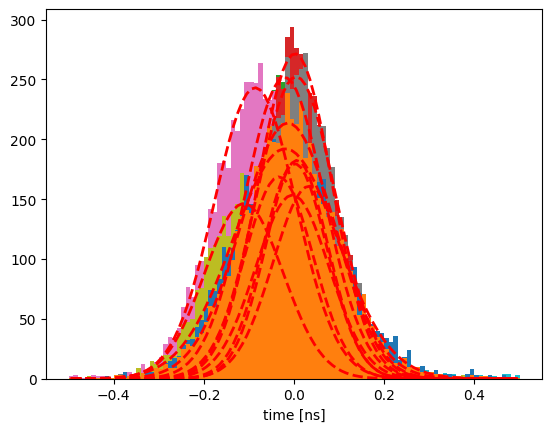

In [7]:
improvements = {}
for i, (plane, channel) in enumerate(train_X_list.keys()):
    print(f'Processing p={plane}, ch={channel}...')

    X_train = np.concatenate(list(train_X_list.values())[:i] + list(train_X_list.values())[i + 1:])
    y_train = np.concatenate(list(train_y_list.values())[:i] + list(train_y_list.values())[i + 1:])
    X_test = test_X_list[(plane, channel)]
    y_test = test_y_list[(plane, channel)]

    Y_heatmap_train = np.array([gaussian_kernel(y) for y in y_train])
    Y_heatmap_test = np.array([gaussian_kernel(y) for y in y_test])

    model = optimal_model_builder_ch_2_11()
    history = train_model(model, f"optimal_test_{plane}_{channel}", X_train=X_train, y_train=Y_heatmap_train, X_val=X_test,
                          y_val=Y_heatmap_test, train=False, verbose=0)

    cfd = CFD(n_baseline=N_BASELINE, threshold=optimal_cfd_thresholds[(plane, channel)])

    y_pred_cfd = cfd.predict(X_TIME, X_test)
    std_cfd, _, _ = plot_difference_hist(y_test, y_pred_cfd, show=False, close=False)

    y_pred_model = model_predict(model, X_test)
    std_model, _, _ = plot_difference_hist(y_test, y_pred_model, show=False, close=False)

    compare_results([std_model], ["optimal"], std_cfd)
    improvements[(plane, channel)] = (std_cfd, std_model, 1 - std_model / std_cfd)

In [8]:
print('Improvements:')
for (plane, channel), improv in improvements.items():
    print(
        f'({plane:>1}, {channel:>2}) CFD: {improv[0] * 1000:6.2f} ps, NN: {improv[1] * 1000:6.2f} ({improv[2] * 100:5.2f} %)')

Improvements:
(1,  2) CFD:  76.08 ps, NN:  69.44 ( 8.72 %)
(1, 11) CFD:  88.03 ps, NN:  81.58 ( 7.33 %)
(2,  2) CFD:  80.13 ps, NN:  71.49 (10.79 %)
(2, 11) CFD:  90.39 ps, NN:  87.78 ( 2.88 %)
(3,  2) CFD:  86.67 ps, NN:  81.47 ( 6.00 %)
(3, 11) CFD: 115.86 ps, NN: 103.37 (10.78 %)
